In [1]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

from tqdm import tqdm,tqdm_notebook
import re
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk

df_train = pd.read_csv('train.tsv', '\t')
df_train.shape

(1482535, 8)

The mercari dataset has a total of 8 columns and 1,482,535 rows

In [2]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity


## Checking for Null values

<AxesSubplot:>

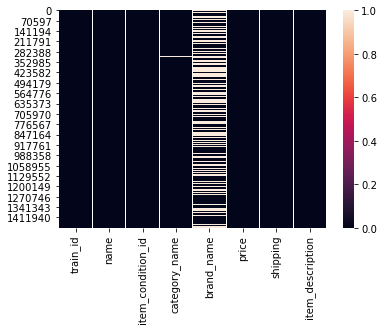

In [3]:
sns.heatmap(df_train.isnull())

# Price Column

## Summary on price column

In [4]:
df_train['price'].describe().apply(lambda x: format(x, 'f'))

count    1482535.000000
mean          26.737516
std           38.586066
min            0.000000
25%           10.000000
50%           17.000000
75%           29.000000
max         2009.000000
Name: price, dtype: object

## Price Distribution Plot

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


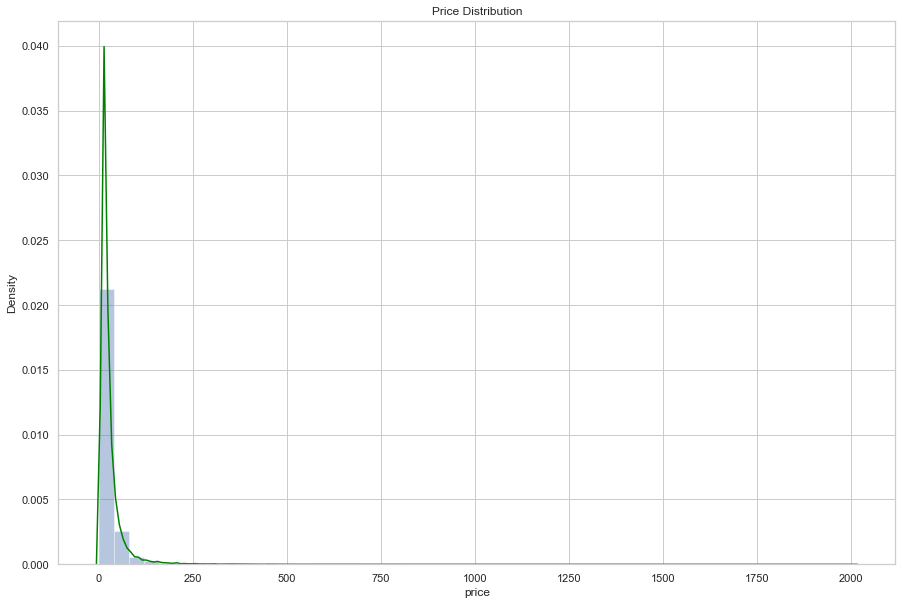

In [5]:
sns.set(rc={'figure.figsize':(15,10)})
sns.set_theme(style = "whitegrid")
sns.distplot(df_train.price, kde_kws = {"color" : "green"})
plt.title('Price Distribution')
plt.show()

## Percentiles of price

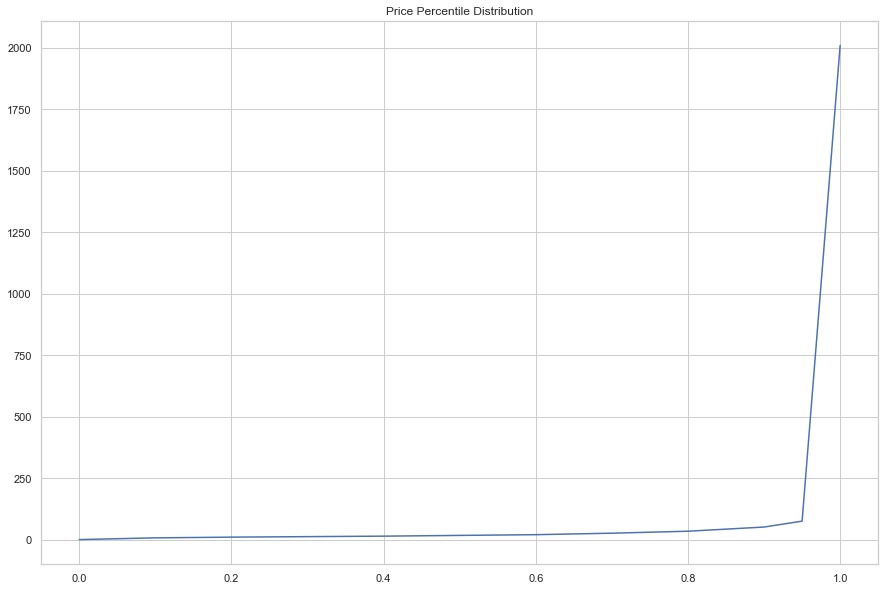

In [6]:
percentiles = df_train['price'].quantile([0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, .9, 0.95, 1 ])
plt.plot(percentiles)
plt.title('Price Percentile Distribution')
plt.show()

The above plot shows a huge jump from 90th percentile onwards. We can deep dive into the 90-100 percentile to understand the inflection point.

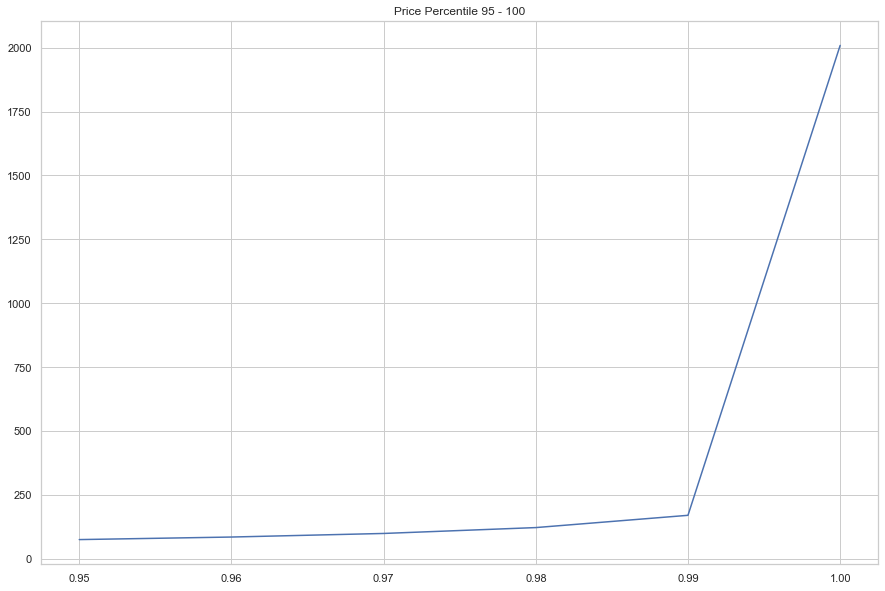

In [7]:
percentiles = df_train['price'].quantile([0.95, 0.96, 0.97, 0.98, 0.99, 1 ])
plt.plot(percentiles)
plt.title('Price Percentile 95 - 100')
plt.show()

From the above plot, we can observe that the inflection point occurs after 99th percentile.

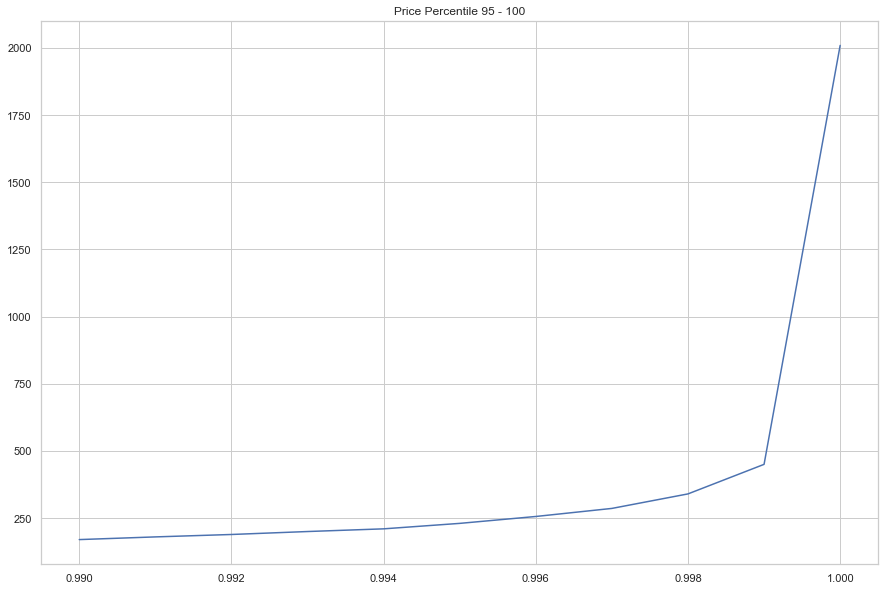

In [8]:
percentiles = df_train['price'].quantile([0.99, 0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999, 1 ])
plt.plot(percentiles)
plt.title('Price Percentile 95 - 100')
plt.show()

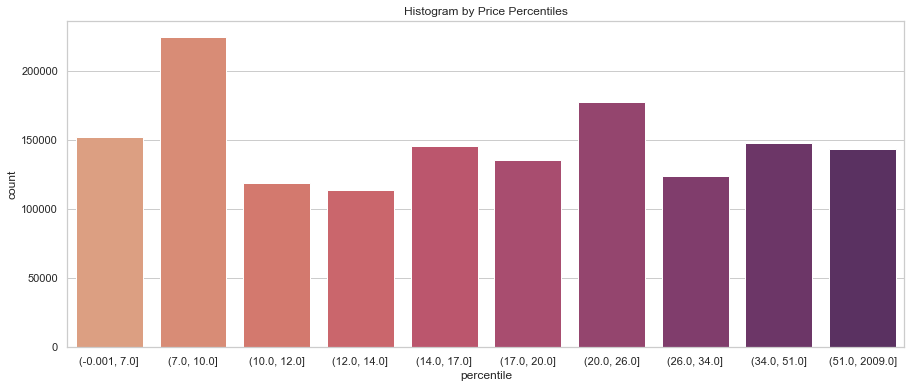

In [9]:
df_train['percentile'] = pd.qcut(df_train.price, q=np.arange(0,1.1,0.1))
df_tempo = pd.DataFrame(df_train.groupby('percentile').agg('size').reset_index())
df_tempo.columns = ['percentile','count']

sns.set(rc={'figure.figsize':(15,6)}, style = 'whitegrid')
sns.barplot(x = "percentile", y = "count", data = df_tempo, palette = "flare")
plt.title('Histogram by Price Percentiles')
plt.show()

Most of the mercari product prices fall in the range of [7 - 10] . At least 100,000 Item Listings in each bucket, showing an even distribution.

## Plotting log distribution of price

Text(0.5, 1.0, 'Price Distribution')

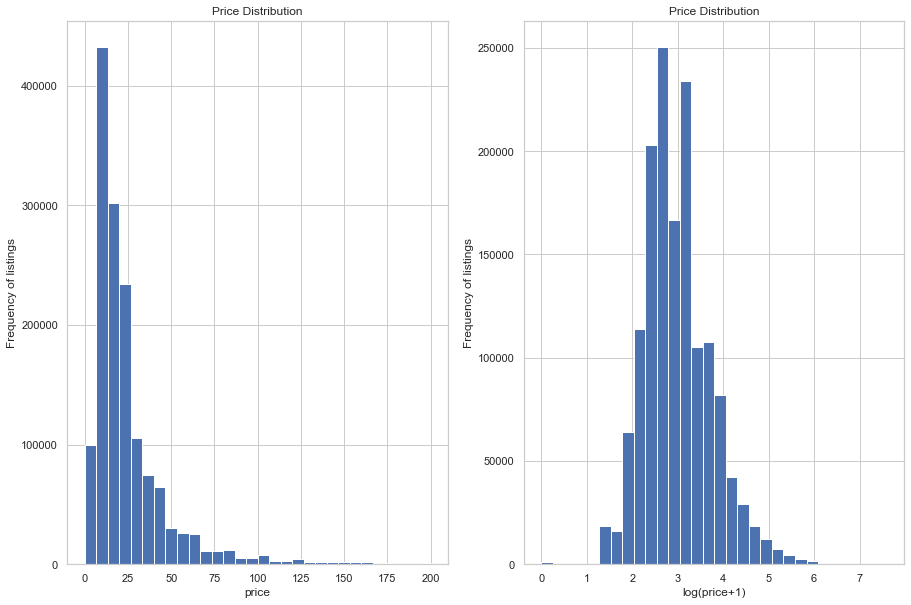

In [10]:
#left skewed price distribution so log transform
plt.subplot(1, 2, 1)
(df_train['price']).plot.hist(bins=30, figsize=(15, 10), edgecolor = 'white', range = [0, 200])
plt.xlabel('price', fontsize=12)
plt.ylabel('Frequency of listings')
plt.title('Price Distribution', fontsize=12)

plt.subplot(1, 2, 2)
np.log(df_train['price']+1).plot.hist(bins=30, figsize=(15,10), edgecolor='white')
plt.xlabel('log(price+1)', fontsize=12)
plt.ylabel('Frequency of listings')
plt.title('Price Distribution', fontsize=12)

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


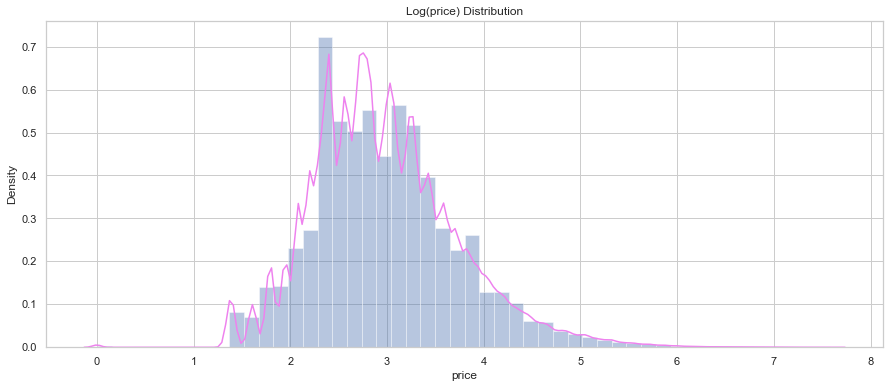

In [11]:
df_train['lg_price'] = np.log1p(df_train['price'])
sns.set(rc={'figure.figsize':(15,6)}, style = 'whitegrid')
sns.distplot(np.log1p(df_train.price), kde_kws = {"color" : "violet"})
plt.title('Log(price) Distribution')
plt.show()

# Shipping Column

In [12]:
df_train.groupby('shipping')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
shipping,,,,,,,,
0,819435.0,30.111778,39.53592,0.0,13.0,20.0,33.0,2009.0
1,663100.0,22.567726,36.95579,0.0,8.0,14.0,25.0,2000.0


In [13]:
# % shipping fee paid by buyers 0-buyer 1-seller
df_train['shipping'].value_counts() / len(df_train)

0    0.552726
1    0.447274
Name: shipping, dtype: float64

55.27 % fees paid by buyers
44.73% fees paid by seller

In [14]:
seller_charged = []
buyer_charged = []
for i in tqdm(range(0,len(df_train['shipping']))):
    if df_train['shipping'][i]==0:
        seller_charged.append(df_train['lg_price'][i])
    else:
        buyer_charged.append(df_train['lg_price'][i])

100%|██████████| 1482535/1482535 [00:19<00:00, 74258.12it/s]


## Price distribution grouped by the shipping (by seller or buyer)

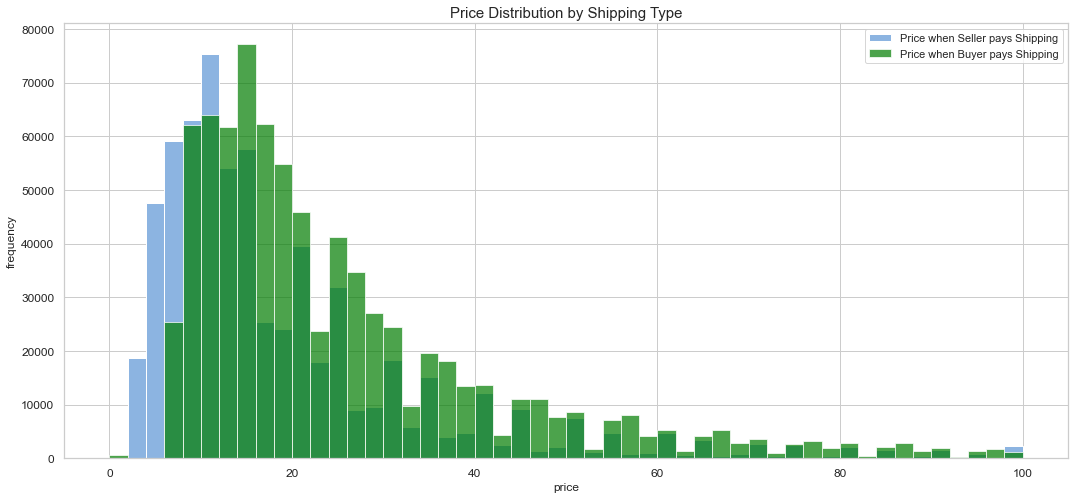

In [15]:
shipping_fee_by_buyer = df_train.loc[df_train['shipping'] == 0, 'price']
shipping_fee_by_seller = df_train.loc[df_train['shipping'] == 1, 'price']

fig, ax = plt.subplots(figsize=(18,8))
ax.hist(shipping_fee_by_seller, color='#8CB4E1', alpha=1.0, bins=50, range = [0, 100],
       label='Price when Seller pays Shipping')
ax.hist(shipping_fee_by_buyer, color='#007D00', alpha=0.7, bins=50, range = [0, 100],
       label='Price when Buyer pays Shipping')
plt.xlabel('price', fontsize=12)
plt.ylabel('frequency', fontsize=12)
plt.title('Price Distribution by Shipping Type', fontsize=15)
plt.tick_params(labelsize=12)
plt.legend()
plt.show()

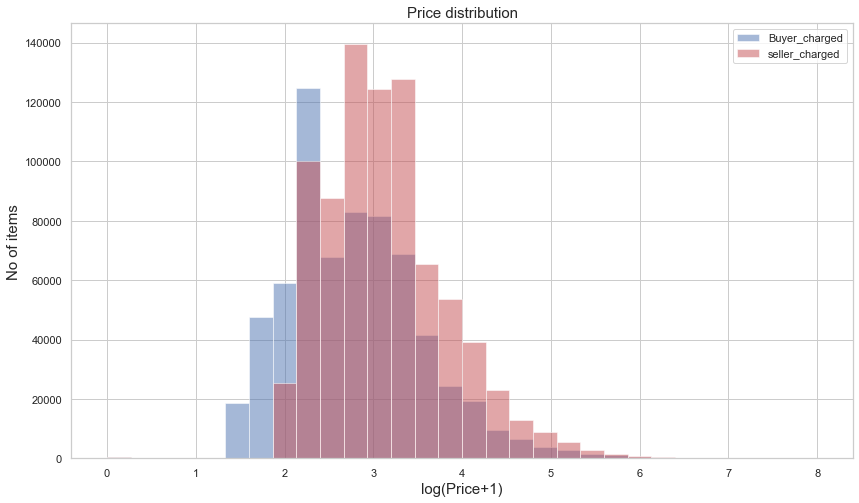

In [16]:
fig, ax = plt.subplots(figsize=(14,8))
ax.hist(buyer_charged,bins=30,range=[0,8],label="Buyer_charged",color='b',alpha=0.5)
ax.hist(seller_charged,bins=30,range=[0,8],label="seller_charged",color='r',alpha=0.5)
plt.title('Price distribution', fontsize=15)
ax.set_xlabel('log(Price+1)',fontsize=15)
ax.set_ylabel('No of items',fontsize=15)
plt.legend(loc='upper right')

## Violin plot on price variations by shipping

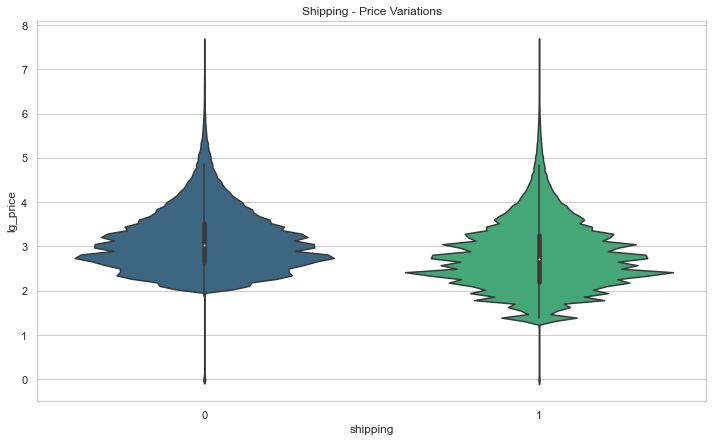

In [17]:
sns.set(rc={'figure.figsize':(12,7)}, style = 'whitegrid')
sns.violinplot(x = "shipping", y = "lg_price", data = df_train, palette = "viridis")
plt.title('Shipping - Price Variations')
plt.show()

Shipping = 1 (Shipping paid by seller)

In the violin plot, we observe that values for shipping = 1 is lower than shipping = 0. 
However, what we need to find out is whether this difference is significant to us.
We can utilise the ANOVA test to show the significance of this column


ANOVA TEST :https://statistics.laerd.com/statistical-guides/one-way-anova-statistical-guide.php  An ANOVA test is used to find out if an experiment results are significant. It helps you figure out if you need to reject the null hypothesis or accept the alternate hypothesis. Testing groups to see if there's a difference between them.

If you get a large f value (one that is bigger than the F critical value found in a table), it means something is significant, while a small p value means all your results are significant. 

## Anova Test

In [18]:
from scipy.stats import f_oneway

stat, p = f_oneway(df_train.price.values[df_train.shipping == 0], df_train.price.values[df_train.shipping == 1])
print('F - Statistics = %.9f, p = %.9f' % (stat, p))

#alpha = 0.05
if p > 0.05:
    print('Same distributions - Fail to reject hypothesis H0')
else:
    print('Different distributions - We reject H0, accept alternative hypothesis')

F - Statistics = 14143.607688957, p = 0.000000000
Different distributions - We reject H0, accept alternative hypothesis


There is a significant difference and 'p' value is quite negligible (0).

Conclusion: There is a significant enough difference between the 2 shipping categories in the price values.

# Item condition

In [19]:
df_train.groupby('item_condition_id')['price'].describe()

,count,mean,std,min,25%,50%,75%,max
item_condition_id,,,,,,,,
1,640549.0,26.486967,35.418024,0.0,10.0,18.0,30.00,2009.0
2,375479.0,27.563225,42.125698,0.0,11.0,17.0,29.00,2004.0
3,432161.0,26.540711,40.030681,0.0,11.0,16.0,28.00,2000.0
4,31962.0,24.349212,35.679148,0.0,10.0,15.0,26.00,1309.0
5,2384.0,31.703859,39.531069,0.0,11.0,19.0,35.25,522.0


item condition ids:

1 - New (codes: BNWT, BNIP MIB, NWT, NIB, BNIB)

2 - Like New (codes: BNWOT, MWOB, NWOT, BNWOB)

3 - Good

4 - Fair

5 - Poor

## Violin plot on price variation by item condition

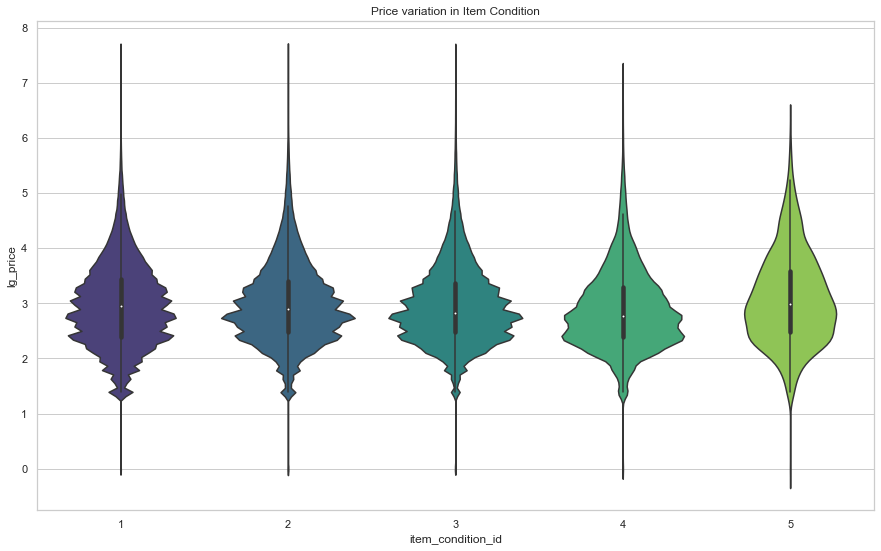

In [20]:
sns.set(rc={'figure.figsize':(15,9)}, style = 'whitegrid')
sns.violinplot(x = "item_condition_id", y = "lg_price", data = df_train , palette = "viridis")
plt.title('Price variation in Item Condition')
plt.show()

## Anova Test

In [21]:
stat, p = f_oneway(df_train.price.values[df_train.item_condition_id == 1],
                   df_train.price.values[df_train.item_condition_id == 2],
                   df_train.price.values[df_train.item_condition_id == 3],
                   df_train.price.values[df_train.item_condition_id == 4],
                   df_train.price.values[df_train.item_condition_id == 5])

print('F - Statistics = %.9f, p = %.9f' % (stat, p))

#alpha = 0.05
if p > 0.05:
    print('Same distributions - Fail to reject hypothesis H0')
else:
    print('Different distributions - We reject H0, accept alternative hypothesis')

F - Statistics = 93.055869753, p = 0.000000000
Different distributions - We reject H0, accept alternative hypothesis


There is a significant difference and 'p' value is quite negligible (0).

Conclusion: There is a significant enough difference between the item id in the price values.

# Brand Name

Earlier in the EDA, we found that the brand column had a siginificant amount of null values.

In [22]:
print("Percentage of missing values in brand column : " ,df_train.brand_name.isnull().sum()/len(df_train)*100)

Percentage of missing values in brand column :  42.675687251902986


In [23]:
print('There are', df_train['brand_name'].nunique(), 'unique values in brand name column.')

print('There are %d items that do not have a brand name.' %df_train['brand_name'].isnull().sum())

There are 4809 unique values in brand name column.
There are 632682 items that do not have a brand name.


In [24]:
df_brand_name = pd.DataFrame(df_train.groupby('brand_name', as_index = False).agg
                         ({'price': 'mean','shipping' : 'count'}))
df_brand_name.columns = ['brand_name', 'average_price', 'count']

df_brand_name.sort_values(by = ['count'], ascending = False, inplace = True)
df_brand_name['cumul_count'] = df_brand_name['count'].cumsum()
df_brand_name['cumul_percentage'] = df_brand_name['cumul_count']/df_brand_name['count'].sum() * 100
df_brand_name = df_brand_name.reset_index()
df_brand_name.head(10)

,index,brand_name,average_price,count,cumul_count,cumul_percentage
0,3221,PINK,26.341314,54088,54088,6.364395
1,3057,Nike,30.760265,54043,108131,12.723495
2,4504,Victoria's Secret,23.214287,48036,156167,18.375766
3,2604,LuLaRoe,33.667967,31024,187191,22.026280
4,267,Apple,73.268618,17322,204513,24.064515
5,1510,FOREVER 21,12.929935,15186,219699,25.851412
6,3067,Nintendo,34.672619,15007,234706,27.617247
7,2626,Lululemon,47.096717,14558,249264,29.330249
8,2841,Michael Kors,62.254775,13928,263192,30.969121
9,213,American Eagle,15.960955,13254,276446,32.528684


## Finding the percentage of brands that take up the number of listings on Mercari

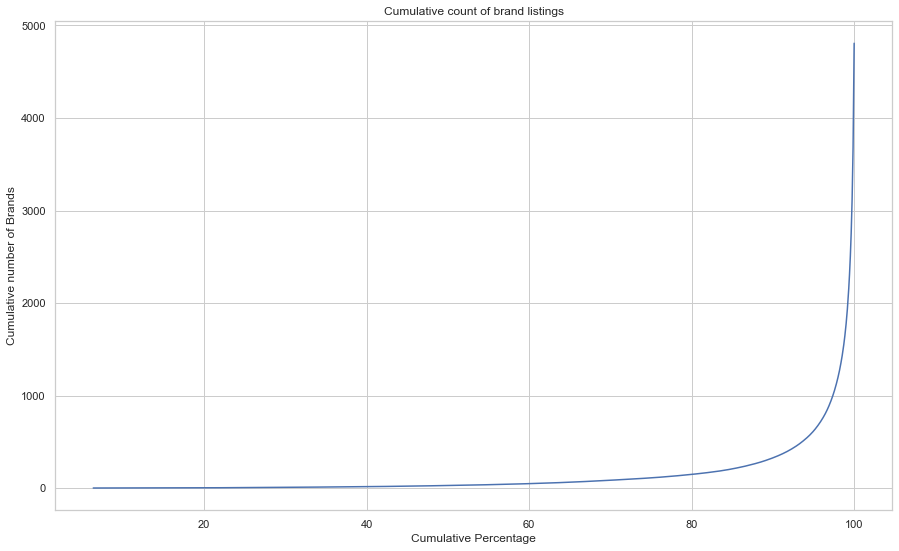

In [25]:
plt.plot(df_brand_name.cumul_percentage, df_brand_name.index)
plt.xlabel('Cumulative Percentage')
plt.ylabel('Cumulative number of Brands')
plt.title('Cumulative count of brand listings')
plt.show()

As observed, majority (more than 90%) of product listings are sold by top 1000 brands

## Brands and their average pricing on Mercari

In [26]:
price_brand = pd.DataFrame(df_train.groupby(['brand_name']).price.mean().reset_index())
price_brand.sort_values(by=['price'], ascending=False, inplace= True)
price_brand.head(10)

,brand_name,price
1222,Demdaco,429.000000
3465,Proenza Schouler,413.250000
346,Auto Meter,344.000000
3187,Oris,300.000000
2656,MCM Worldwide,289.173913
2582,Longines,254.000000
4528,Vitamix,253.111111
598,Blendtec,251.800000
1198,David Yurman,248.611570
881,Celine,238.780822


## Brands and their average price

/opt/anaconda3/lib/python3.8/site-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


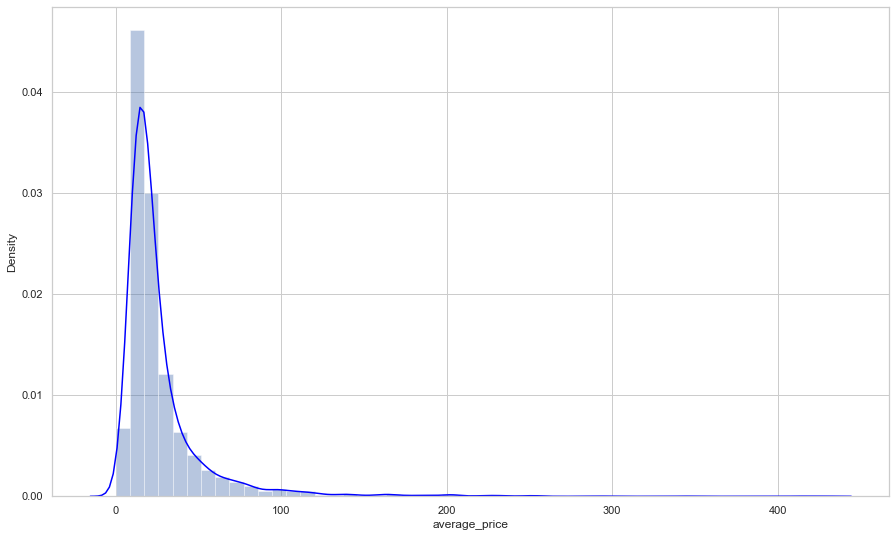

In [27]:
sns.set(rc={'figure.figsize':(15,9)}, style = 'whitegrid')
sns.distplot(df_brand_name.average_price, kde_kws = {"color" : "blue"})
plt.show()

Most brands have average price ranges from 20 - 30

# Category Name

<AxesSubplot:>

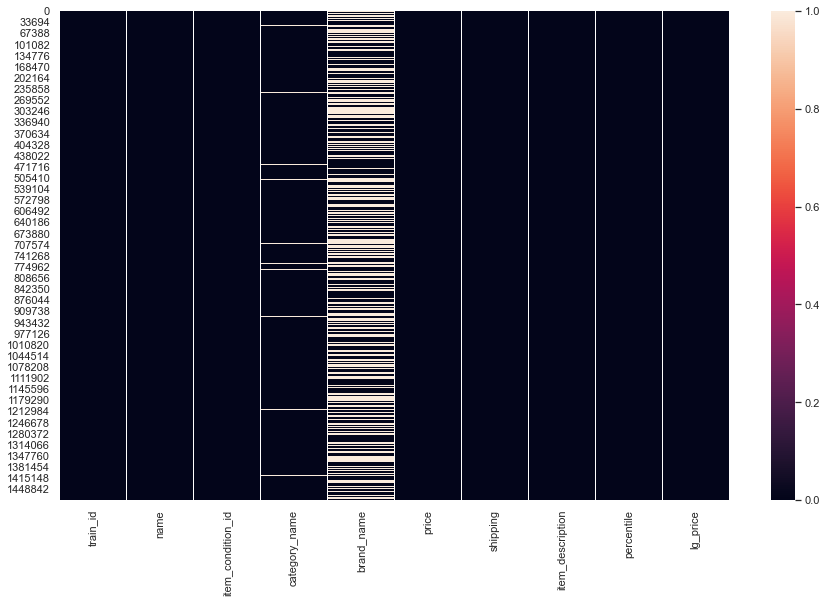

In [28]:
sns.heatmap(df_train.isnull())

As seen from the heatmap, we can see that category_name column has missing values. 

In [29]:
print('Percentage of category name missing:', df_train.category_name.isnull().sum()/len(df_train) * 100)

Percentage of category name missing: 0.42676901388500105


In [30]:
print('Number of unique values in category names:' , df_train.category_name.nunique() )

Number of unique values in category names: 1287


In [31]:
print('There are %d items that do not have a category name.' %df_train['category_name'].isnull().sum())

There are 6327 items that do not have a category name.


In [32]:
df_train.category_name.values

array(['Men/Tops/T-shirts',
       'Electronics/Computers & Tablets/Components & Parts',
       'Women/Tops & Blouses/Blouse', ...,
       'Sports & Outdoors/Exercise/Fitness accessories',
       'Home/Home Décor/Home Décor Accents',
       "Women/Women's Accessories/Wallets"], dtype=object)

Category names are separated by the '/' delimiter. We observe that there are a few sub categories.


## Finding the levels of category

In [33]:
df_train['category_split'] = df_train['category_name'].str.split('/')

In [34]:
df_train['category_levels'] = df_train['category_split'].str.len()
 
df_train['category_levels'].unique()

array([ 3., nan,  5.,  4.])

In [35]:
df_train['category_levels'].value_counts()

3.0    1471819
5.0       3059
4.0       1330
Name: category_levels, dtype: int64

We observe that category levels generally occurs in 3, 4, 5 levels. We can proceed to split these categories into 5 columns

In [36]:
df_train[['cat_1','cat_2','cat_3','cat_4','cat_5']] = df_train['category_name'].str.split('/', 0, expand=True)

In [37]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,percentile,lg_price,category_split,category_levels,cat_1,cat_2,cat_3,cat_4,cat_5
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,"(7.0, 10.0]",2.397895,"[Men, Tops, T-shirts]",3.0,Men,Tops,T-shirts,None,None
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,"(51.0, 2009.0]",3.970292,"[Electronics, Computers & Tablets, Components ...",3.0,Electronics,Computers & Tablets,Components & Parts,None,None
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,"(7.0, 10.0]",2.397895,"[Women, Tops & Blouses, Blouse]",3.0,Women,Tops & Blouses,Blouse,None,None
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,"(34.0, 51.0]",3.583519,"[Home, Home Décor, Home Décor Accents]",3.0,Home,Home Décor,Home Décor Accents,None,None
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,"(34.0, 51.0]",3.806662,"[Women, Jewelry, Necklaces]",3.0,Women,Jewelry,Necklaces,None,None


In [38]:
print(df_train['cat_1'].nunique())
print(df_train['cat_2'].nunique())
print(df_train['cat_3'].nunique())
print(df_train['cat_4'].nunique())
print(df_train['cat_5'].nunique())

10
113
870
7
3


There are only 10 categories for 'cat 1'. Cat 1 is assumed to be the main category name.

In [39]:
price_cat = pd.DataFrame(df_train.groupby(['cat_1', 'cat_2', 'cat_3']).lg_price.mean().reset_index())
price_cat.sort_values(by=['lg_price'], ascending=False, inplace= True)
price_cat.head(10)

,cat_1,cat_2,cat_3,lg_price
962,Vintage & Collectibles,Antique,Furniture,5.278115
680,Kids,Strollers,Standard,4.727229
457,Home,Home Appliances,Air Conditioners,4.591767
89,Electronics,Computers & Tablets,Laptops & Netbooks,4.540497
677,Kids,Strollers,Lightweight,4.494951
406,Handmade,Woodworking,Sports,4.465908
87,Electronics,Computers & Tablets,Desktops & All-In-Ones,4.445344
681,Kids,Strollers,Travel Systems,4.407042
817,Other,Automotive,Oils & Fluids,4.376067
1283,Women,Women's Handbags,Satchel,4.364994


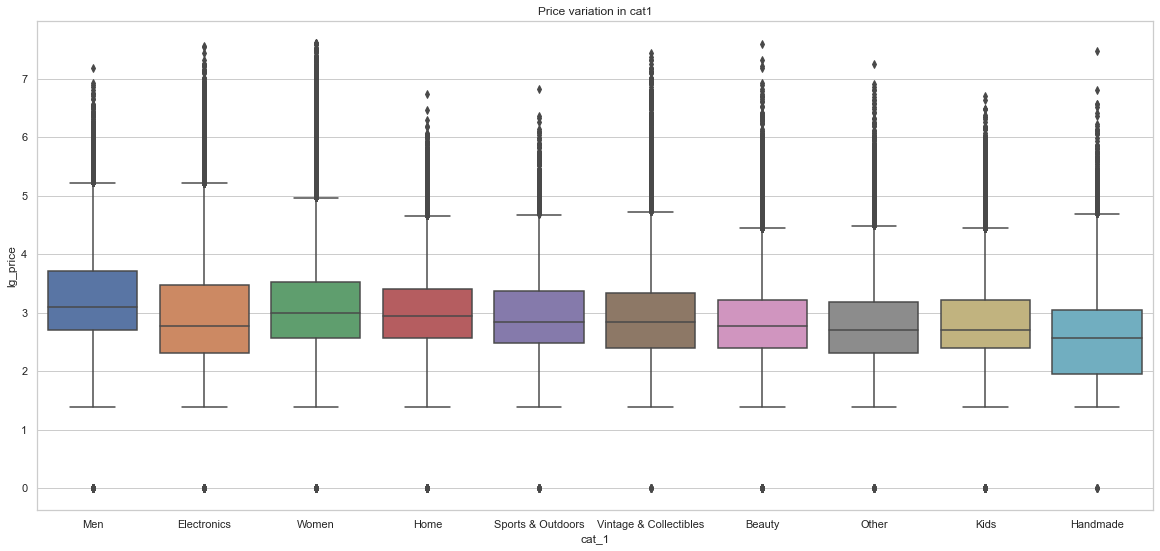

In [40]:
sns.set(rc={'figure.figsize':(20,9)}, style = 'whitegrid')
sns.boxplot(x = "cat_1", y = "lg_price", data = df_train)
plt.title('Price variation in cat1')
plt.show()

Men category has the highest MEDIAN price
Handmade category has the lowest MEDIAN price

In [41]:
df_train['cat_1'].describe()

count     1476208
unique         10
top         Women
freq       664385
Name: cat_1, dtype: object

## Category Word Cloud

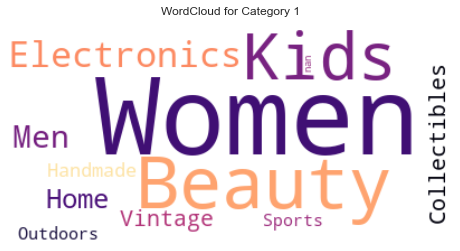

In [42]:
from wordcloud import WordCloud
cat_1_texts = " ".join(cat for cat in df_train.cat_1.values.astype(str))

cloud = WordCloud(collocations=False, 
                     colormap= 'magma',
                      background_color='white').generate(cat_1_texts)
plt.figure(figsize = (8,5))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud for Category 1')
plt.show()

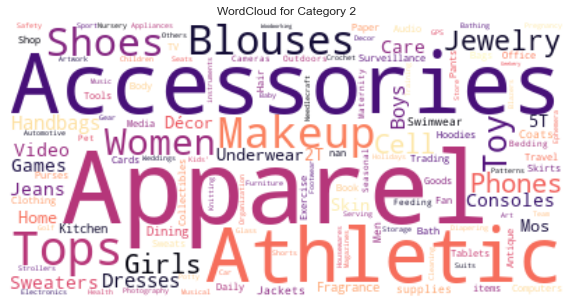

In [43]:
cat_2_texts = " ".join(cat for cat in df_train.cat_2.values.astype(str))
cloud = WordCloud(collocations=False, 
                     colormap= 'magma',
                      background_color='white').generate(cat_2_texts)
plt.figure(figsize = (10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud for Category 2')
plt.show()

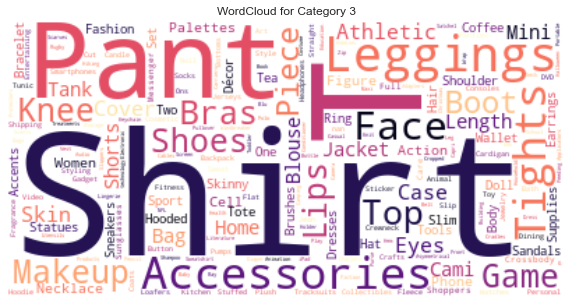

In [44]:
cat_3_texts = " ".join(cat for cat in df_train.cat_3.values.astype(str))
cloud = WordCloud(collocations=False, 
                     colormap= 'magma',
                      background_color='white').generate(cat_3_texts)
plt.figure(figsize = (10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud for Category 3')
plt.show()

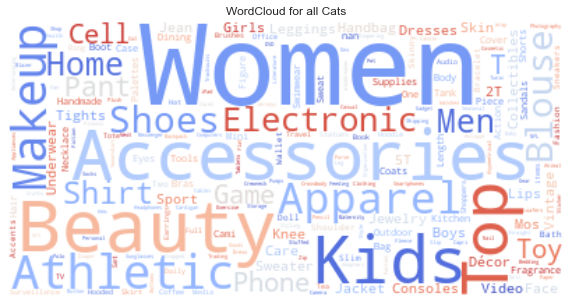

In [45]:
all_texts = cat_1_texts + cat_2_texts + cat_3_texts
cloud = WordCloud(collocations=False, 
                     colormap= 'coolwarm',
                      background_color='white').generate(all_texts)
plt.figure(figsize = (10,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud for all Cats')
plt.show()

## Name Column

In [46]:
# ref - www.appliedaicourse.com/
''' This code performs text processing by cleaning text including 
removing stopwords, reemoving special characters, performing, word decontraction etc. '''

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
stopwords= ['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"]

def text_preprocess(data):
    preprocessed = []
    for sentance in tqdm_notebook(data):
        sent = decontracted(sentance)
        sent = sent.replace('\\r', ' ')
        sent = sent.replace('\\"', ' ')
        sent = sent.replace('\\n', ' ')
        sent = re.sub('[^A-Za-z0-9]+', ' ', sent)
        # https://gist.github.com/sebleier/554280
        sent = ' '.join(e for e in sent.split() if e not in stopwords)
        preprocessed.append(sent.lower().strip())
    return preprocessed

In [47]:
from tqdm import tqdm,tqdm_notebook
import re
from nltk.stem import WordNetLemmatizer, SnowballStemmer,PorterStemmer
from nltk.stem.porter import *
import nltk

df_train['process_name'] = text_preprocess(df_train['name'])

<ipython-input-46-3990bd2009da>:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentance in tqdm_notebook(data):


In [48]:
df_train.head(5)

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,percentile,lg_price,category_split,category_levels,cat_1,cat_2,cat_3,cat_4,cat_5,process_name
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,"(7.0, 10.0]",2.397895,"[Men, Tops, T-shirts]",3.0,Men,Tops,T-shirts,None,None,mlb cincinnati reds t shirt size xl
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,"(51.0, 2009.0]",3.970292,"[Electronics, Computers & Tablets, Components ...",3.0,Electronics,Computers & Tablets,Components & Parts,None,None,razer blackwidow chroma keyboard
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,"(7.0, 10.0]",2.397895,"[Women, Tops & Blouses, Blouse]",3.0,Women,Tops & Blouses,Blouse,None,None,ava viv blouse
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,"(34.0, 51.0]",3.583519,"[Home, Home Décor, Home Décor Accents]",3.0,Home,Home Décor,Home Décor Accents,None,None,leather horse statues
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,"(34.0, 51.0]",3.806662,"[Women, Jewelry, Necklaces]",3.0,Women,Jewelry,Necklaces,None,None,24k gold plated rose


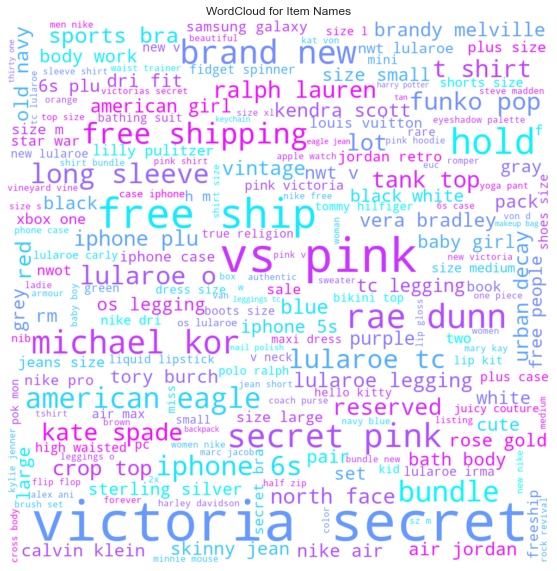

In [49]:
names = " ".join(cat for cat in df_train.process_name.values.astype(str))
cloud = WordCloud(width = 1000, height = 1000,
                     colormap= 'cool',
                      background_color='white').generate(names)
plt.figure(figsize = (20, 10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud for Item Names')
plt.show()

# Item Description Column

In [50]:
print('Missing values in item description: ', df_train.item_description.isnull().sum())

Missing values in item description:  4


In [51]:
df_train['item_description'] = df_train['item_description'].replace([np.nan,'No description'], '')

In [52]:
df_train['itemdesc_process'] = text_preprocess(df_train['item_description'])

<ipython-input-46-3990bd2009da>:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for sentance in tqdm_notebook(data):


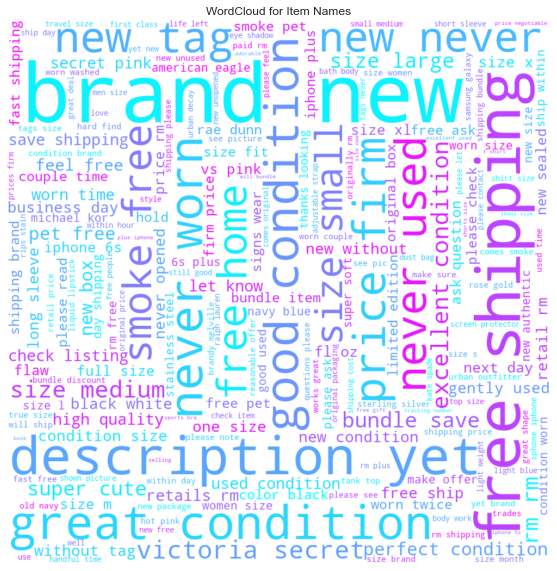

In [53]:
item_names = " ".join(cat for cat in df_train.itemdesc_process.values.astype(str))
cloud = WordCloud(width = 1000, height = 1000,
                     colormap= 'cool',
                      background_color='white').generate(item_names)
plt.figure(figsize = (20,10))
plt.imshow(cloud, interpolation='bilinear')
plt.axis("off")
plt.title('WordCloud for Item Names')
plt.show()

## Item Description Length

In [54]:
def length(description):
    count = 0
    for i in description.split():
        count+=1
    return count

In [59]:
new = []
for i in df_train['item_description']:
    temp = []
    temp.append(i)
    temp.append(length(str(i)))
    new.append(temp)

print(new[0])
print(len(new))

['No description yet', 3]
1482535


In [60]:
new_df = pd.DataFrame( new ,columns=['desc','desc_length'])
print(new_df.head(2))

                                                desc  desc_length
0                                 No description yet            3
1  This keyboard is in great condition and works ...           36


In [62]:
df_train['description_len'] = new_df['desc_length']

In [63]:
df_train.head()

,train_id,name,item_condition_id,category_name,brand_name,price,shipping,item_description,percentile,lg_price,category_split,category_levels,cat_1,cat_2,cat_3,cat_4,cat_5,process_name,itemdesc_process,description_len
0,0,MLB Cincinnati Reds T Shirt Size XL,3,Men/Tops/T-shirts,NaN,10.0,1,No description yet,"(7.0, 10.0]",2.397895,"[Men, Tops, T-shirts]",3.0,Men,Tops,T-shirts,None,None,mlb cincinnati reds t shirt size xl,no description yet,3
1,1,Razer BlackWidow Chroma Keyboard,3,Electronics/Computers & Tablets/Components & P...,Razer,52.0,0,This keyboard is in great condition and works ...,"(51.0, 2009.0]",3.970292,"[Electronics, Computers & Tablets, Components ...",3.0,Electronics,Computers & Tablets,Components & Parts,None,None,razer blackwidow chroma keyboard,this keyboard great condition works like came ...,36
2,2,AVA-VIV Blouse,1,Women/Tops & Blouses/Blouse,Target,10.0,1,Adorable top with a hint of lace and a key hol...,"(7.0, 10.0]",2.397895,"[Women, Tops & Blouses, Blouse]",3.0,Women,Tops & Blouses,Blouse,None,None,ava viv blouse,adorable top hint lace key hole back the pale ...,29
3,3,Leather Horse Statues,1,Home/Home Décor/Home Décor Accents,NaN,35.0,1,New with tags. Leather horses. Retail for [rm]...,"(34.0, 51.0]",3.583519,"[Home, Home Décor, Home Décor Accents]",3.0,Home,Home Décor,Home Décor Accents,None,None,leather horse statues,new tags leather horses retail rm stand foot h...,32
4,4,24K GOLD plated rose,1,Women/Jewelry/Necklaces,NaN,44.0,0,Complete with certificate of authenticity,"(34.0, 51.0]",3.806662,"[Women, Jewelry, Necklaces]",3.0,Women,Jewelry,Necklaces,None,None,24k gold plated rose,complete certificate authenticity,5


<AxesSubplot:xlabel='description_len', ylabel='price'>

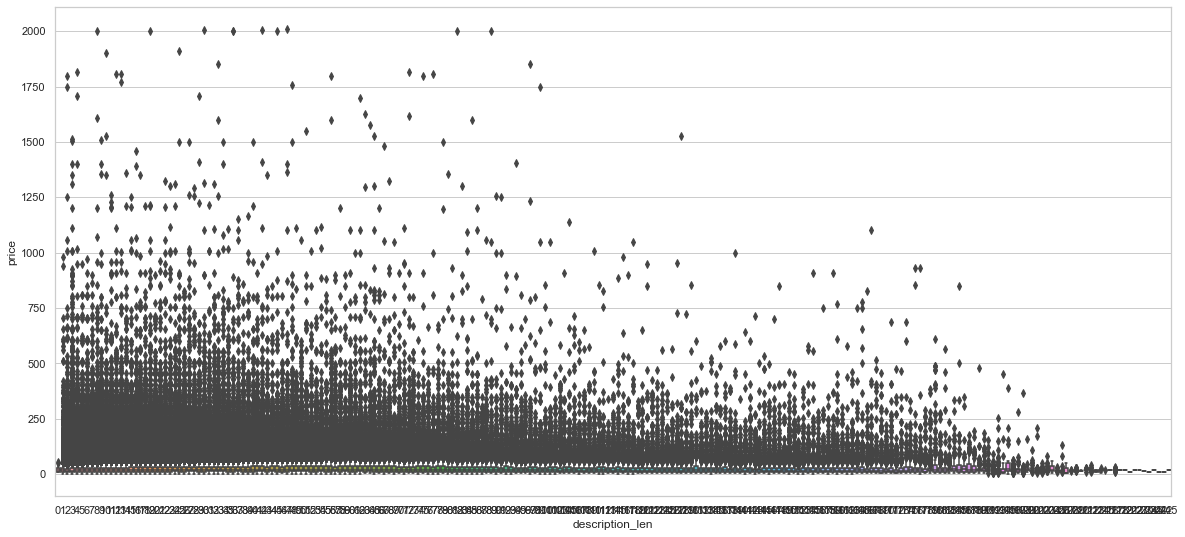

In [64]:
sns.boxplot(x=df_train.description_len,y=df_train.price,orient='v')

Item description length shows correlation with price, making it a useful feature for us to use in our price modelling